#### Taken initial fund value, expected withdrawals, expected monthly return, inflation and Fisher management fee,
#### simulate fund values over time using Monte Carlo

In [1]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt

from generateRandomSample import generateRandomSample

In [2]:
def getData():
    # Get the historical monthly returns from MSCI World
    tmp = pd.read_html('~/data/investing/benchmark/MSCI.html')
    df = tmp[0]
    df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(x))
    df.rename(columns={'Date': 'date', 'Close': 'value'}, inplace=True)
    return df[['date', 'value']]

In [3]:
def filterDate(startDT):
    # Filter by date, format yyyy-mm-01. Earliest is 1978-12-01
    return df[df['date'] >= startDt]

In [4]:
def getFundval(fundVal, data):
    # 'data' has monthly withdrawals and growth. Compute the monthly account value
    # based on those two, then save the December values ('count%12')
    eoyVals = []
    count=0
    for wd, ret in data:
        if withdrawalFirst:
            fundVal -= wd
            fundVal *= ret
        else:
            fundVal *= ret
            fundVal -= wd
        fee = calcFee(fundVal)
        fundVal = int(fundVal - fee)
        if count%12 == 0:
            eoyVals.append(fundVal)
        count+=1
    return eoyVals

In [5]:
def calcFee(fundVal):
    # This is the fee paid to Fisher
    tier1 = .0125
    tier2 = .01125
    tier3 = .01
    if fundVal < 1e6:
        fee = tier1 * fundVal
    elif fundVal < 5e6:
        fee = 12500 + tier2*(fundVal-1e6)
    else:
        fee = 12500 + 45000 + tier3*(fundVal-5e6)
    return max(0, fee/12)

##### Set some constants

In [6]:
# Key is annual return; value is monthly equivalent
MSCIreturns = {
    '5%': 1.004074,
    '6%': 1.0048672,
    '7%': 1.005654,
    '8%': 1.006434,
    '9%': 1.007207,
    '10%': 1.007974
}

# Initial fund value
currentFund = 2.7e6
# Initial monthly withdrawal amount
initWD = int(7000)
# Annual inflation rate
annualInflationRate = 0.022
# How far out to forecast
numYears = 19
# Do you withdraw first or apply the return first?
withdrawalFirst = False
# MSCI avg return
rate = '6%'
# MSCI avg Std Dev of monthly returns
std = .04
# This is how long (years) the fund will accumulate before we start the withdrawals
wdDelay = 5
startDt = '2000-12-01'
assert rate in MSCIreturns.keys(), "invalid growth rate"

In [7]:
monthlyInflationRate = 1+npf.rate(nper=12, pmt=0, pv=-100, fv=100*(1+annualInflationRate))
withdrawals = [initWD *np.power(monthlyInflationRate, x) for x in range(numYears * 12)]

##### Confirm monthly growth rate is equivalent to annual

In [8]:
monthlyGrowthRate = MSCIreturns[rate]
fv = npf.fv(monthlyGrowthRate-1, nper=12, pmt=0, pv=-100)
print("MSCI return annualized: {:.2%}".format((fv-100)/100))

MSCI return annualized: 6.00%


##### Get the MSCI historical data and compute some metrics

In [9]:
df = getData()
df = filterDate(startDt)

##### Grow the fund value until withdrawals begin. The future value is not a "point" forecast but is stochastic, subject to monthly return variability

In [14]:
# Number of months of growth until withdrawals begin
numMonths = wdDelay * 12

fundvals = []
for _ in range(1000):
    returns = generateRandomSample(monthlyGrowthRate, std, numMonths)
    tmp = currentFund
    for x in returns:
        tmp *= x
        fee = calcFee(tmp)
        tmp -= fee
    fundvals.append(tmp)

##### Now start withdrawing; initial withdrawal amount is increased monthly by inflation rate

In [15]:
# Run a series of simulations
# For each simulation, generate monthly returns drawn from the Normal distribution
l = []
fcastLength = numYears * 12
returns = generateRandomSample(monthlyGrowthRate, std, fcastLength)
for fv in fundvals:
    data = zip(withdrawals, returns)
    eoyVals = getFundval(fv, data)
    endingVal = eoyVals[-1]
    l.append(endingVal)

In [16]:
neg = [x for x in l if x < 0]
below0 = len(neg) / len(l)
print("{:.0%} likelihood of running below 0".format(below0))

1% likelihood of running below 0


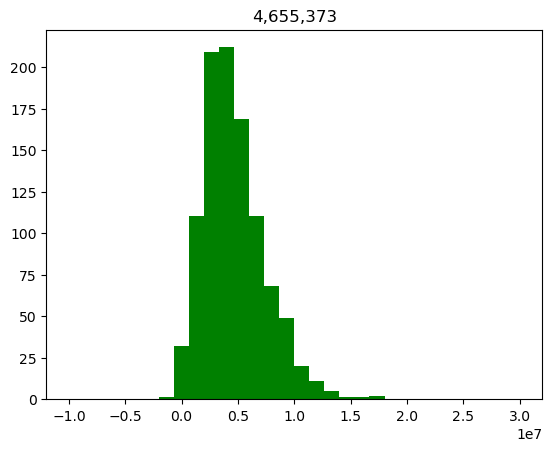

In [17]:
plt.hist(l, 30, range=[-1e7, 3e7], facecolor='green', align='mid')
plt.title("{:,}".format(int(sum(l)/len(l))))
plt.show()